In [1]:
import itertools
import os

import numpy as np
import pandas as pd
from plotnine import *

In [2]:
fuzzers = ['zest', 'bedivfuzz', 'bedivfuzz-split']
subjects = ['ant', 'bcel', 'chocopy', 'closure', 'maven', 'nashorn', 'pngj', 'rhino', 'tomcat']
num_trials = 30
timeout = 180

In [3]:
def trial_df(experiment_name: str, fuzzer: str, subject: str, trial: int):
    df = pd.read_csv(
        os.path.join('results', experiment_name, fuzzer, subject, f'trial-{trial}', 'plot_data'),
        skipinitialspace=True
    )

    if fuzzer == 'bedivfuzz-split':
        zest_plot_data = pd.read_csv(
            os.path.join('results', experiment_name , fuzzer, subject, f'trial-{trial}', 'zest-results', 'plot_data'),
            skipinitialspace=True
        )

        df = pd.concat([zest_plot_data, df], ignore_index=True)

    # one datapoint per minute
    df = df.loc[np.linspace(0, len(df)-1, timeout, endpoint=True, dtype=np.int64)]
    df['time'] = range(1, timeout+1)
    df['trial'] = trial
    df['fuzzer'] = fuzzer
    df['subject'] = subject
    df['validity_rate'] = df['valid_inputs'] / (df['valid_inputs'] + df['invalid_inputs'])

    if 'unique_valid_paths' in df.columns:
        return df[[
            'fuzzer', 'subject', 'trial', 'time', 
            'valid_inputs', 'invalid_inputs', 'validity_rate', 'unique_paths', 'unique_valid_paths',
            'num_coverage_probes', 'num_semantic_probes', 'b0', 'b1', 'b2'
        ]]

    else:
        return df[[
                'fuzzer', 'subject', 'trial', 'time', 
                'valid_inputs', 'invalid_inputs', 'validity_rate', 'unique_paths',
                'num_coverage_probes', 'num_semantic_probes', 'b0', 'b1', 'b2'
            ]]

In [4]:
def load_results(experiment_name):
    dfs = []
    for f, s, t in itertools.product(fuzzers, subjects, range(1, num_trials+1)):
        dfs.append(trial_df(experiment_name, fuzzer=f, subject=s, trial=t))
    trials = pd.concat(dfs)
    return trials

In [14]:
metrics_default = load_results('eval-bedivfuzz-metrics-default')

In [16]:
metric = 'unique_valid_paths'
mean_thesis_default = metrics_default.groupby(['fuzzer', 'subject', 'time'])[metric].agg(mean_score='mean', sem=lambda y: y.std() / np.sqrt(len(y)))
mean_thesis_default['min_score'] = mean_thesis_default['mean_score'] - mean_thesis_default['sem']
mean_thesis_default['max_score'] = mean_thesis_default['mean_score'] + mean_thesis_default['sem']

/Users/lam/_projects/bedivfuzz/.venv/lib/python3.11/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



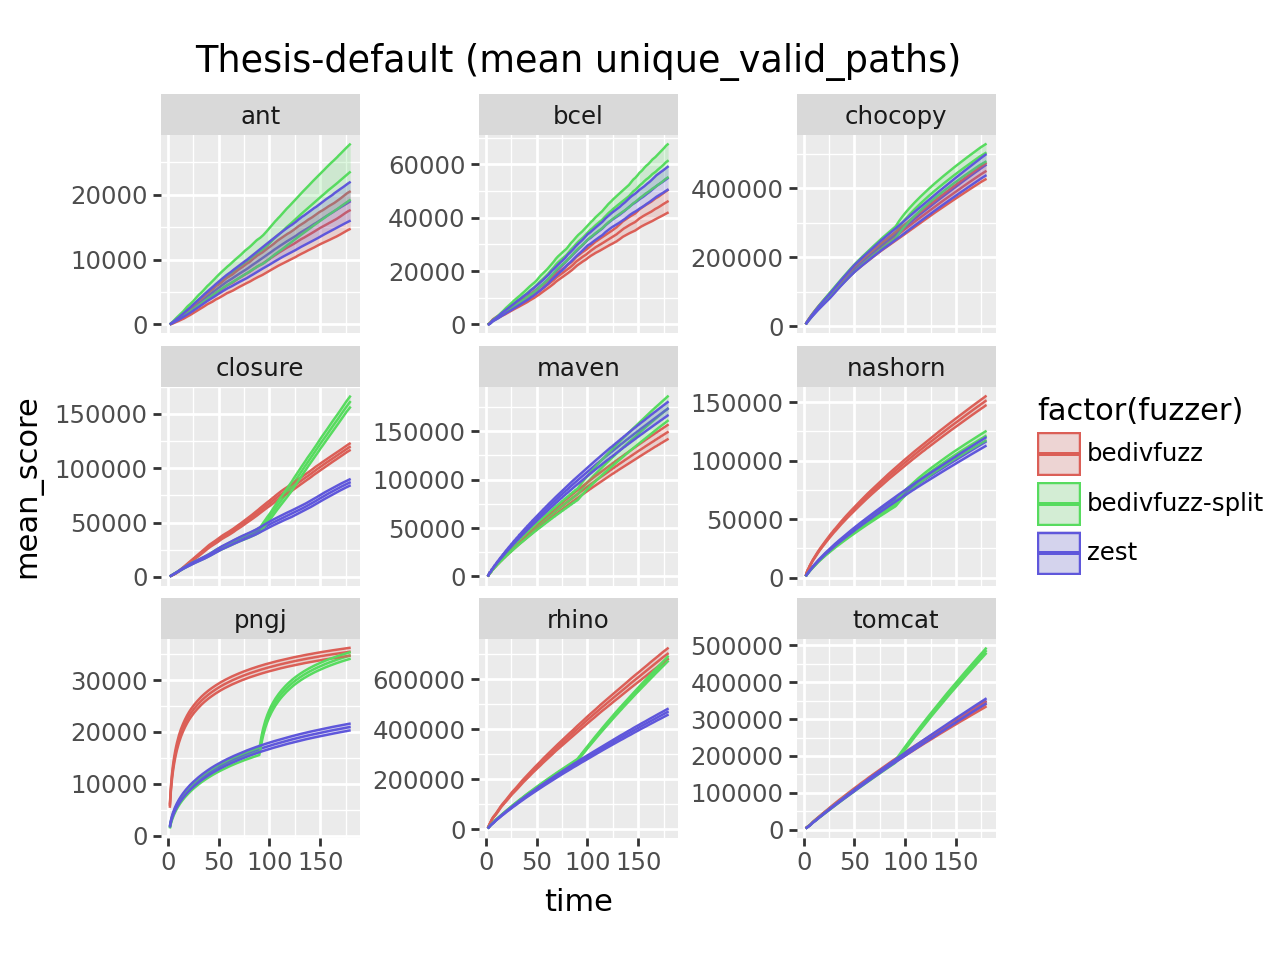

In [17]:
(ggplot(mean_thesis_default.reset_index().query("time > 1"), aes("time", "mean_score", color="factor(fuzzer)", fill="factor(fuzzer)"))
 + geom_line()
 + geom_ribbon(aes(ymin = "min_score", ymax = "max_score"), alpha = 0.2)
 + facet_wrap("~subject", scales="free_y")
 + theme(aspect_ratio = 1.0)
 + ggtitle(f"Thesis-default (mean {metric})")
)

/Users/lam/_projects/bedivfuzz/.venv/lib/python3.11/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



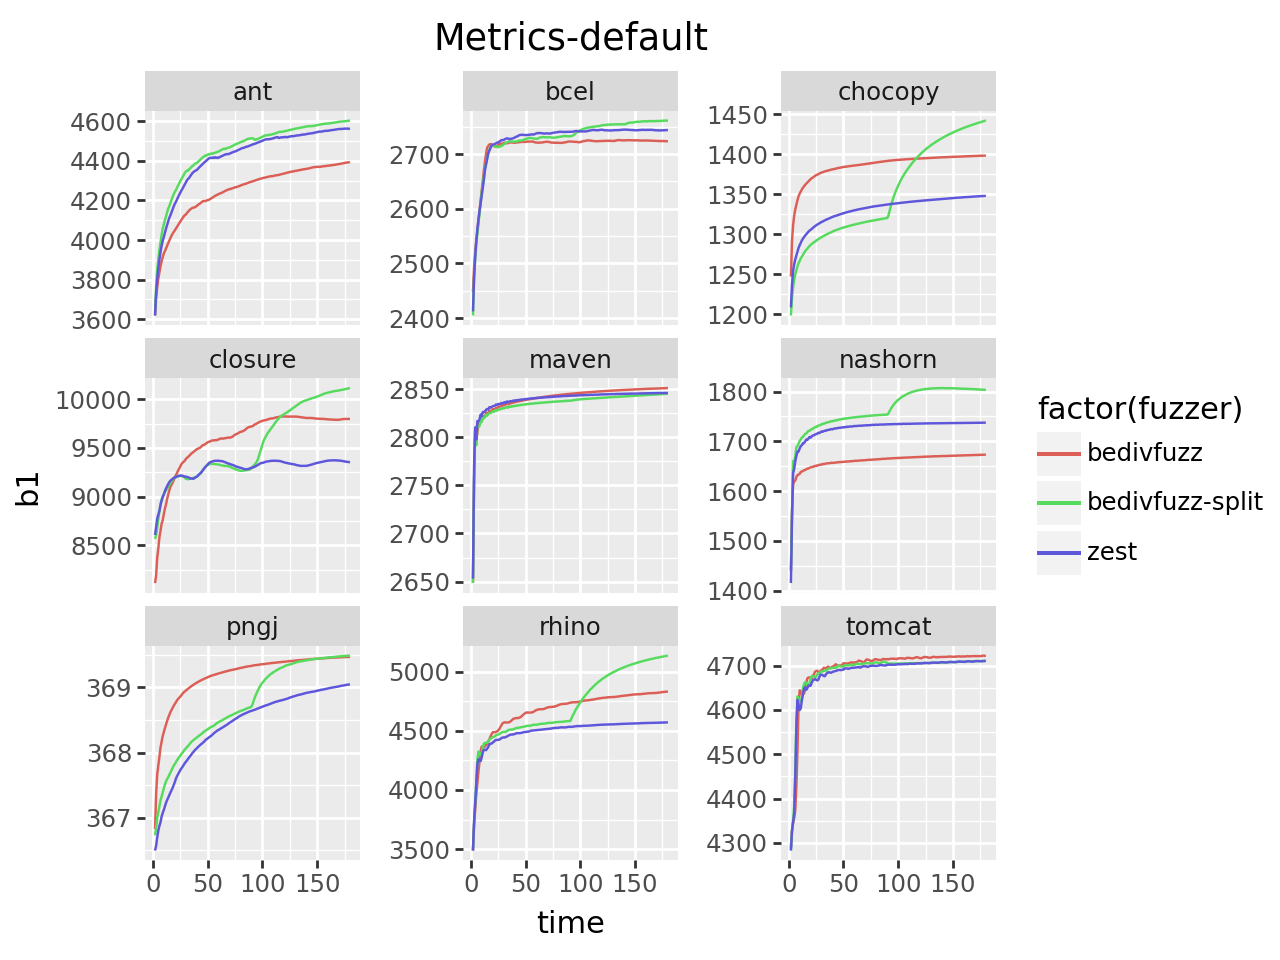

In [77]:
(ggplot(metrics_default.reset_index().query("time > 1"), aes("time", metric, color="factor(fuzzer)"))
 + geom_line()
 + facet_wrap("~subject", scales="free_y")
 + theme(aspect_ratio = 1.0)
 + ggtitle('Metrics-default')
)

/Users/lam/_projects/bedivfuzz/.venv/lib/python3.11/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



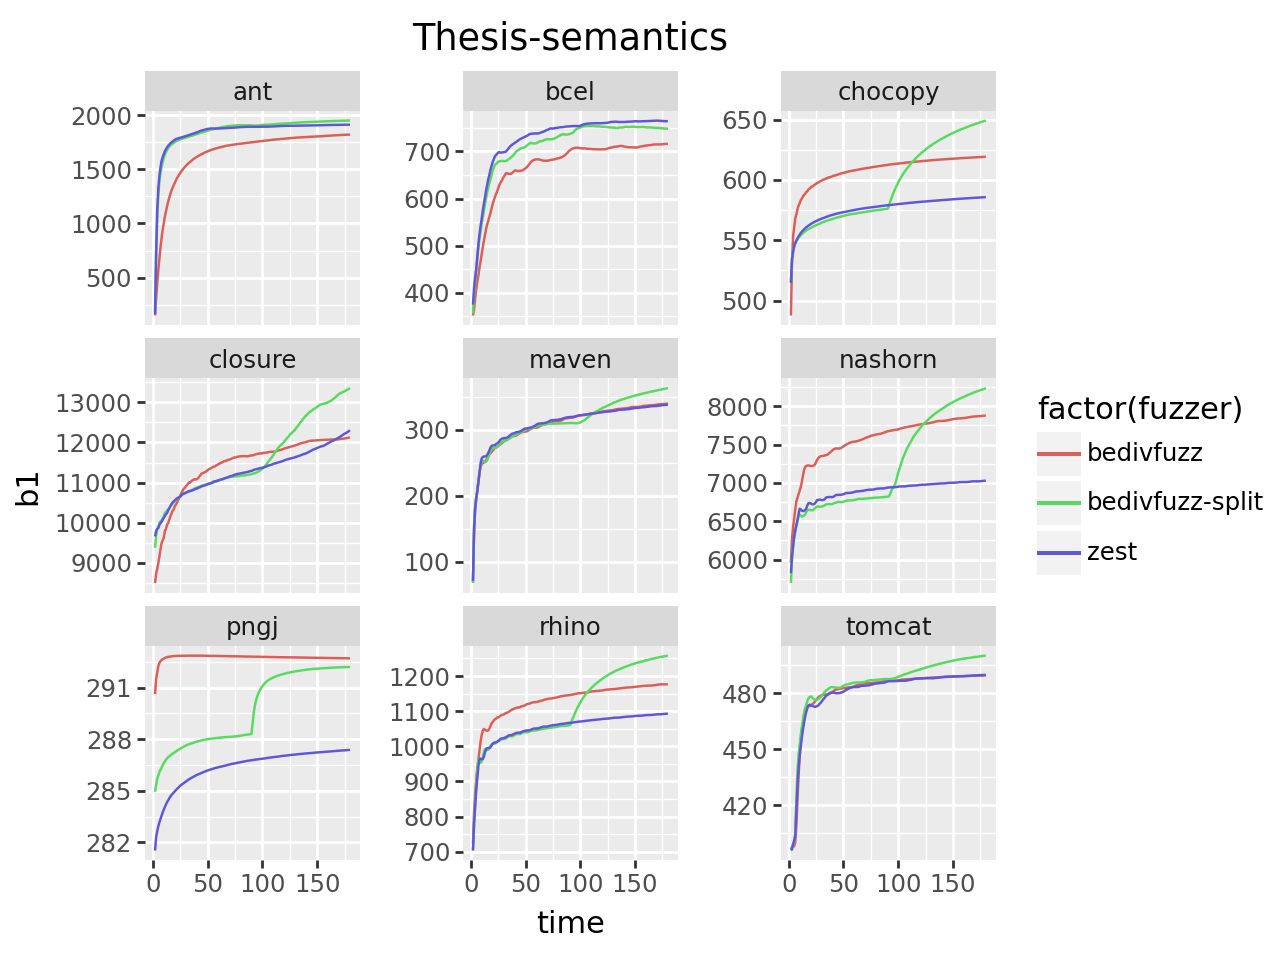

In [78]:
(ggplot(thesis_semantic.reset_index().query("time > 1"), aes("time", metric, color="factor(fuzzer)"))
 + geom_line()
 + facet_wrap("~subject", scales="free_y")
 + theme(aspect_ratio = 1.0)
 + ggtitle('Thesis-semantics')
)

/Users/lam/_projects/bedivfuzz/.venv/lib/python3.11/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



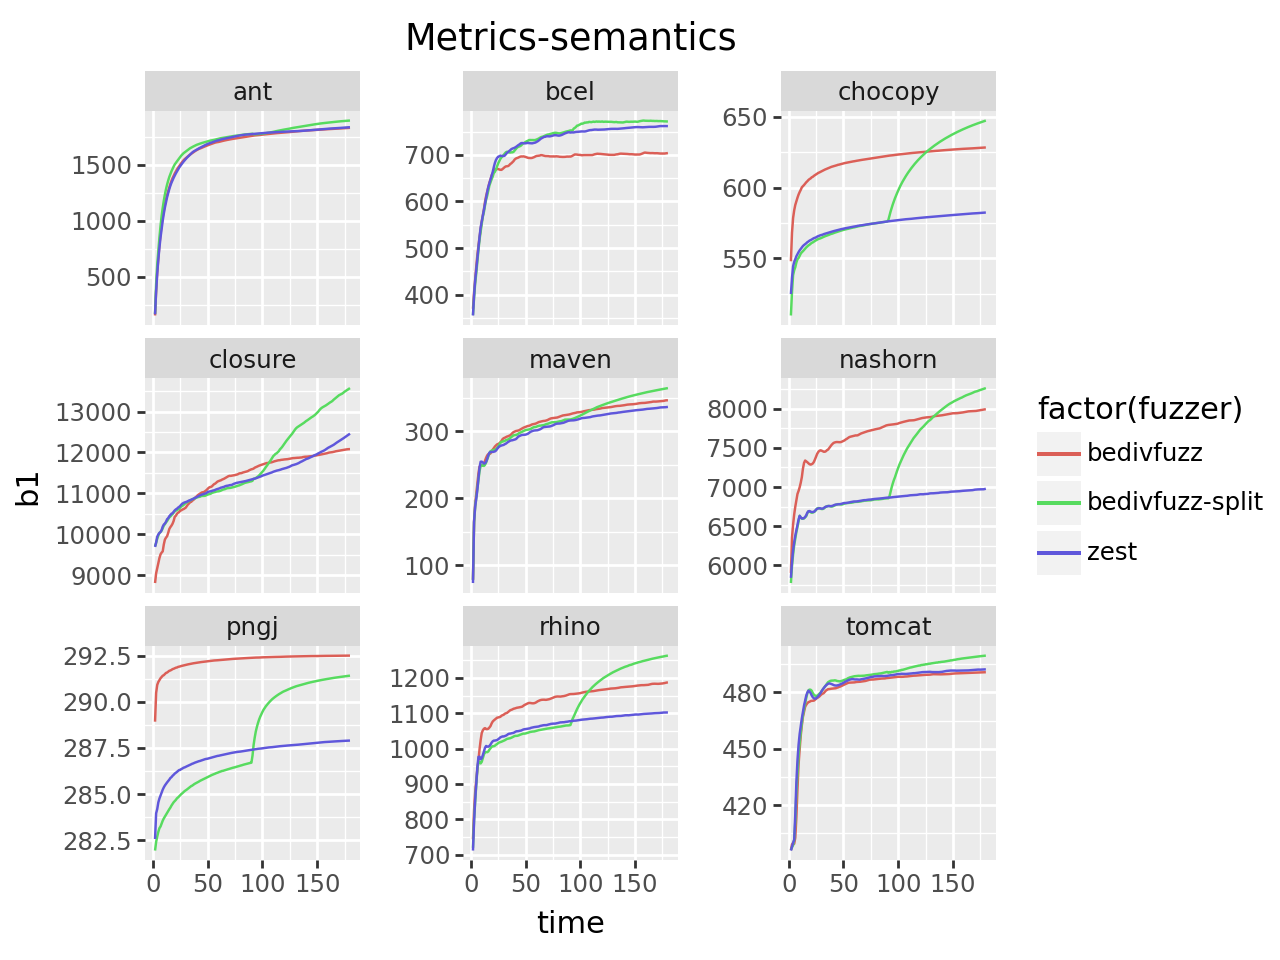

In [79]:
(ggplot(metrics_semantic.reset_index().query("time > 1"), aes("time", metric, color="factor(fuzzer)"))
 + geom_line()
 + facet_wrap("~subject", scales="free_y")
 + theme(aspect_ratio = 1.0)
 + ggtitle('Metrics-semantics')
)

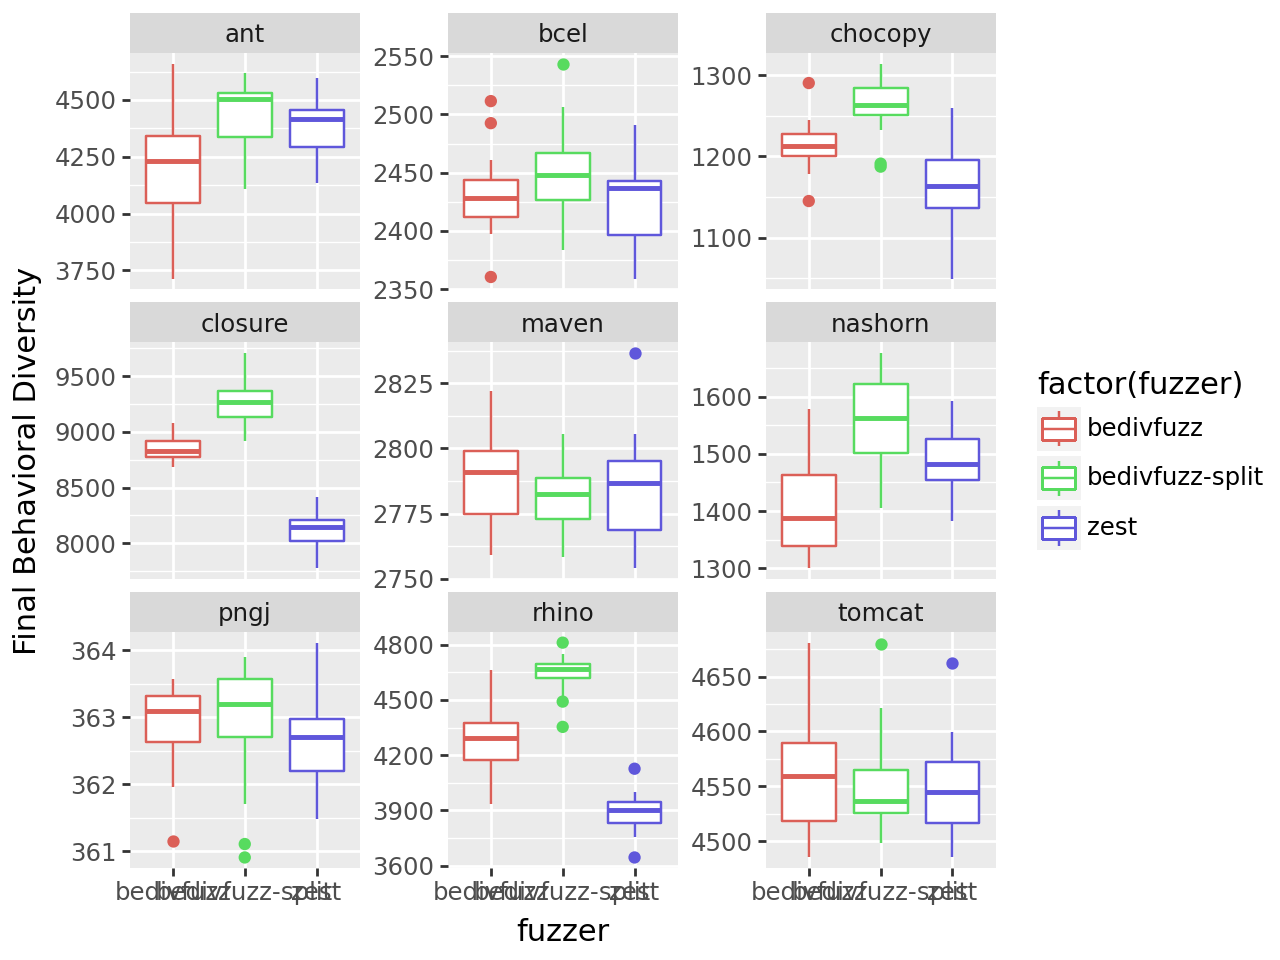

In [80]:
final_scores = trials.loc[trials['time'] == 180]

(ggplot(final_scores, aes("fuzzer", "b2", color="factor(fuzzer)"))
 + geom_boxplot()
 + facet_wrap("~subject", scales="free_y")
 + ylab("Final Behavioral Diversity")
)

In [8]:
trials.loc[trials['time'] == 180]

,fuzzer,subject,trial,time,valid_inputs,invalid_inputs,validity_rate,unique_paths,unique_valid_paths,num_coverage_probes,num_semantic_probes,b0,b1,b2
3410,zest,ant,1,180,23252,204620,0.102040,82238,14413,128171,92573,6799.0,4362.16,4136.16
3391,zest,ant,2,180,25064,67869,0.269700,50411,16394,128201,92655,6238.0,4619.30,4453.97
3389,zest,ant,3,180,28162,67120,0.295565,48153,18463,128201,92655,6239.0,4611.85,4449.71
3383,zest,ant,4,180,23166,64679,0.263714,52402,15667,127944,92014,6869.0,4635.02,4459.46
3378,zest,ant,5,180,25785,91207,0.220400,63386,17260,127855,91830,6238.0,4487.60,4282.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3586,bedivfuzz-split,tomcat,16,180,817803,59202,0.932495,604823,563501,94960,10694,7355.0,4657.81,4505.45
3584,bedivfuzz-split,tomcat,17,180,639195,78672,0.890409,527117,469528,94960,10694,6768.0,4731.44,4564.12
3585,bedivfuzz-split,tomcat,18,180,585065,132010,0.815905,505681,414433,94960,10694,7353.0,4863.98,4679.46
3585,bedivfuzz-split,tomcat,19,180,667666,80689,0.892178,539666,483636,94960,10694,7306.0,4730.69,4565.45


In [9]:
import scipy.stats as stats

In [10]:
metric = 'b1'
alpha = 0.01
time = 180
for s in subjects:
    x = trials.query(f"fuzzer == 'zest' and subject == '{s}' and time == {time}")[metric].to_numpy()
    y = trials.query(f"fuzzer == 'bedivfuzz-split' and subject == '{s}' and time == {time}")[metric].to_numpy()

    if stats.mannwhitneyu(x, y, alternative='two-sided').pvalue < alpha:
        print(f"{s.ljust(10)}: {'zest' if np.mean(x) > np.mean(y) else 'bedivfuzz'}")
    else:
        print(f"{s.ljust(10)}: not significant")


ant       : not significant
bcel      : not significant
chocopy   : bedivfuzz
closure   : bedivfuzz
maven     : not significant
nashorn   : bedivfuzz
pngj      : not significant
rhino     : bedivfuzz
tomcat    : not significant


In [11]:
import math

crash_to_id = {}
def deduplicate_crash(exception_class, stack_trace):
    key = (exception_class, '-'.join(str(stack_trace).split('-')[:3]))
    if str(exception_class) == 'nan' or "OutOfMemoryError" in str(exception_class):
        return -1
    if key in crash_to_id.keys():
        return crash_to_id[key]
    else:
        crash_id = len(crash_to_id)
        crash_to_id[key] = crash_id
        return crash_id

In [12]:
def crash_trial_df(fuzzer: str, subject: str, trial: int):
    df = pd.read_csv(
        os.path.join(results_base_dir, fuzzer, subject, f'trial-1', 'failure_info.csv'),
        skipinitialspace=True
    )

    df['trial'] = trial
    df['fuzzer'] = fuzzer
    df['subject'] = subject
    df['crash_id'] = df.apply(lambda row: deduplicate_crash(row['exception_class'], row['top5_stack_trace']), axis=1)

    return df[['fuzzer', 'subject', 'trial', '# ttd', 'exception_class', 'crash_id']]

In [13]:
crash_dfs = []
for f, s, t in itertools.product(fuzzers, subjects, range(1, num_trials+1)):
    crash_dfs.append(crash_trial_df(fuzzer=f, subject=s, trial=t))
crash_trials = pd.concat(crash_dfs)

In [14]:
crash_trials = crash_trials.loc[crash_trials['crash_id'] != -1]

In [15]:
crash_trials.groupby(['subject', 'fuzzer'])['# ttd'].agg('median').round(0).astype(int)

subject  fuzzer         
bcel     bedivfuzz          6711299
         zest               5136389
closure  bedivfuzz          3266471
         bedivfuzz-split    1181772
         zest               2666400
nashorn  bedivfuzz          3271074
         bedivfuzz-split     284222
         zest               3981318
rhino    bedivfuzz          4136508
         bedivfuzz-split    1143016
         zest               3218541
Name: # ttd, dtype: int64

In [16]:
crash_trials.groupby(['subject', 'fuzzer'])['crash_id'].agg('nunique')

subject  fuzzer         
bcel     bedivfuzz          2
         zest               1
closure  bedivfuzz          2
         bedivfuzz-split    4
         zest               3
nashorn  bedivfuzz          5
         bedivfuzz-split    5
         zest               6
rhino    bedivfuzz          3
         bedivfuzz-split    3
         zest               2
Name: crash_id, dtype: int64

In [17]:
# Deduplicate bugs
crash_trials.groupby(['subject', 'fuzzer', 'trial', 'crash_id'])['# ttd'].agg('min')\
    .groupby(['subject', 'fuzzer', 'crash_id']).agg('mean').round(0).astype(int)

subject  fuzzer           crash_id
bcel     bedivfuzz        0.0         7422675
                          12.0        2016796
         zest             0.0         5136389
closure  bedivfuzz        1.0         5508598
                          3.0         1024345
         bedivfuzz-split  1.0          673854
                          2.0          496391
                          14.0         488741
                          15.0         496759
         zest             1.0         2408553
                          2.0         2666400
                          3.0         4197334
nashorn  bedivfuzz        4.0          590709
                          5.0          186057
                          6.0         6990440
                          7.0          892755
                          8.0          222075
         bedivfuzz-split  4.0          211202
                          5.0           25932
                          6.0          138073
                          8.0           29634

In [37]:
crash_to_id

{('class org.apache.bcel.verifier.exc.AssertionViolatedException',
  'org.apache.bcel.util.ClassPath.getClassFile(ClassPath.java:656)-org.apache.bcel.util.ClassPath.getInputStream(ClassPath.java:705)-org.apache.bcel.util.ClassPath.getInputStream(ClassPath.java:679)'): 0,
 ('class org.apache.bcel.verifier.exc.AssertionViolatedException',
  'java.base/jdk.internal.util.Preconditions.outOfBounds(Preconditions.java:64)-java.base/jdk.internal.util.Preconditions.outOfBoundsCheckIndex(Preconditions.java:70)-java.base/jdk.internal.util.Preconditions.checkIndex(Preconditions.java:248)'): 1,
 ('class java.lang.IllegalStateException',
  'com.google.javascript.jscomp.jarjar.com.google.common.base.Preconditions.checkState(Preconditions.java:590)-com.google.javascript.jscomp.LightweightMessageFormatter.padMultipleLines(LightweightMessageFormatter.java:237)-com.google.javascript.jscomp.LightweightMessageFormatter.getExcerptWithPosition(LightweightMessageFormatter.java:169)'): 2,
 ('class java.lang.Nu

In [38]:
crash_trials.groupby(['subject', 'fuzzer'])['crash_id'].unique()

subject  fuzzer   
bcel     zest                        [0.0, 1.0]
closure  bedivfuzz                   [5.0, 2.0]
         zest         [2.0, 3.0, 4.0, 5.0, 6.0]
rhino    bedivfuzz              [9.0, 8.0, 7.0]
         zest                        [7.0, 8.0]
Name: crash_id, dtype: object

In [39]:
crash_trials.groupby(['subject', 'fuzzer', 'trial', 'crash_id'])['# ttd'].agg('min')\
   .groupby(['subject', 'fuzzer', 'crash_id']).agg('count')

subject  fuzzer     crash_id
bcel     zest       0.0         10
                    1.0         10
closure  bedivfuzz  2.0         10
                    5.0         10
         zest       2.0         10
                    3.0         10
                    4.0         10
                    5.0         10
                    6.0         10
rhino    bedivfuzz  7.0         10
                    8.0         10
                    9.0         10
         zest       7.0         10
                    8.0         10
Name: # ttd, dtype: int64